# 🌿 CSIRO 牧草バイオマス予測モデル

このノートブックは、牧草の画像から乾燥バイオマス量を予測するディープラーニングモデルを訓練・評価します。

## 📋 予測対象
- **Dry_Green_g**: 乾燥緑色植被（三葉草を除く）
- **Dry_Clover_g**: 乾燥三葉草
- **Dry_Dead_g**: 乾燥枯死物質
- **GDM_g**: 緑色乾物質（Green + Clover）
- **Dry_Total_g**: 総乾燥バイオマス

## 📦 ライブラリのインポート

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

# Jupyter環境での表示設定
%matplotlib inline
tqdm.pandas()

print("✅ ライブラリのインポート完了")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ ライブラリのインポート完了


## ⚙️ 設定 (Configuration)

In [2]:
# 訓練モードフラグ
TRAIN = True

# 環境判定
DEBUG = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '') == 'Interactive'
LOCAL = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '') == ''

if LOCAL:
    os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# データルート設定
DATA_ROOT = '../input/' if LOCAL else '/kaggle/input/csiro-biomass/'
OUTPUT_DIR = 'trained_models/'

# モデル設定
MODEL_NAME = 'efficientnet_b2'
NFOLD = 5  # K-Fold交差検証の分割数

# ハイパーパラメータ
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
PATIENCE = 10  # 早期停止の patience
NUM_EPOCHS = 5 if DEBUG else 100

print("🚀 設定完了")
print(f"   - 環境: {'LOCAL' if LOCAL else 'KAGGLE'}")
print(f"   - デバッグモード: {DEBUG}")
print(f"   - 訓練モード: {TRAIN}")

🚀 設定完了
   - 環境: KAGGLE
   - デバッグモード: False
   - 訓練モード: True


## 📊 データ読み込み関数

In [3]:
def load_and_prepare_data(data_root: str, is_train: bool = True) -> pd.DataFrame:
    """
    訓練/テストデータを読み込み、前処理を行います。
    
    Args:
        data_root (str): データディレクトリのルートパス
        is_train (bool): 訓練データの場合True
    
    Returns:
        pd.DataFrame: 前処理済みのDataFrame
    """
    print(f"📂 {'訓練' if is_train else 'テスト'}データ読み込み中...")
    
    filename = 'train.csv' if is_train else 'test.csv'
    df = pd.read_csv(f'{data_root}{filename}')
    
    # sample_idを分割
    df[['sample_id_prefix', 'sample_id_suffix']] = df.sample_id.str.split('__', expand=True)
    
    if is_train:
        # 訓練データは target_name ごとに集約
        cols = ['sample_id_prefix', 'image_path', 'Sampling_Date', 
                'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']
        agg_df = df.groupby(cols).apply(
            lambda group: group.set_index('target_name').target
        )
        agg_df.reset_index(inplace=True)
        agg_df.columns.name = None
    else:
        # テストデータも同様に集約
        df['target'] = 0.0
        cols = ['sample_id_prefix', 'image_path']
        agg_df = df.groupby(cols).apply(
            lambda group: group.set_index('target_name').target
        )
        agg_df.reset_index(inplace=True)
        agg_df.columns.name = None
    
    # 画像を読み込み
    print(f"🖼️  画像読み込み中...")
    agg_df['image'] = agg_df.image_path.progress_apply(
        lambda path: Image.open(data_root + path).convert('RGB')
    )
    
    print(f"✅ データ読み込み完了: {len(agg_df)} サンプル")
    return agg_df


def add_fold_column(df: pd.DataFrame, n_splits: int = 5) -> pd.DataFrame:
    """
    K-Fold交差検証用のfoldカラムを追加します。
    
    Args:
        df (pd.DataFrame): 入力DataFrame
        n_splits (int): 分割数
    
    Returns:
        pd.DataFrame: foldカラムが追加されたDataFrame
    """
    print(f"🔀 {n_splits}-Fold交差検証の分割を作成中...")
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    df['fold'] = None
    
    for i, (_, val_idx) in enumerate(kfold.split(df.index)):
        df.loc[val_idx, 'fold'] = i
    
    print(f"✅ 分割完了")
    return df

## 📥 訓練データの読み込み

In [4]:
train_df = load_and_prepare_data(DATA_ROOT, is_train=True)
train_df = add_fold_column(train_df, NFOLD)

print("\n📈 データ統計:")
print(f"   - 画像サイズ分布:\n{train_df['image'].apply(lambda x: x.size).value_counts()}")

📂 訓練データ読み込み中...
🖼️  画像読み込み中...


/tmp/ipykernel_20/232827819.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_df = df.groupby(cols).apply(


  0%|          | 0/357 [00:00<?, ?it/s]

✅ データ読み込み完了: 357 サンプル
🔀 5-Fold交差検証の分割を作成中...
✅ 分割完了

📈 データ統計:
   - 画像サイズ分布:
image
(2000, 1000)    357
Name: count, dtype: int64


## 🗂️ データセット & DataLoader

In [5]:
class RegressionDataset(Dataset):
    """
    回帰タスク用のPyTorchデータセット。
    
    画像とターゲット値（Dry_Green_g, Dry_Clover_g, Dry_Dead_g）を返します。
    """
    
    def __init__(self, data: pd.DataFrame, transform=None):
        """
        Args:
            data (pd.DataFrame): 画像とターゲットを含むDataFrame
            transform: torchvision.transformsの変換
        """
        self.data = data
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int):
        """
        Args:
            idx (int): インデックス
        
        Returns:
            tuple: (画像Tensor, ターゲットリスト)
        """
        item = self.data.iloc[idx]
        image = item.image

        if self.transform:
            image = self.transform(image)

        targets = [item['Dry_Green_g'], item['Dry_Clover_g'], item['Dry_Dead_g']]
        return image, targets


def create_dataloader(
    data: pd.DataFrame, 
    target_image_size: tuple = (256, 256), 
    batch_size: int = 32, 
    shuffle: bool = True, 
    aug: bool = True
) -> DataLoader:
    """
    DataLoaderを作成します。
    
    Args:
        data (pd.DataFrame): 入力データ
        target_image_size (tuple): リサイズ後の画像サイズ
        batch_size (int): バッチサイズ
        shuffle (bool): シャッフルするかどうか
        aug (bool): データ拡張を行うかどうか
    
    Returns:
        DataLoader: PyTorchのDataLoader
    """
    # データ拡張の設定
    if aug:
        transform = transforms.Compose([
            transforms.Resize(target_image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, 
                                 saturation=0.1, hue=0.05),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(target_image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])

    dataset = RegressionDataset(data, transform=transform)
    print(f"   📦 データセットサイズ: {len(dataset)}")
    
    # num_workersを0に設定してマルチプロセスエラーを回避
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        num_workers=0,  # マルチプロセスエラーを回避
        pin_memory=True if torch.cuda.is_available() else False
    )
    return dataloader

## 📏 評価指標 (Metrics)

In [6]:
def weighted_r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
    """
    重み付きR²スコアを計算します。
    
    5つのターゲット（Green, Clover, Dead, GDM, Total）に対して
    異なる重みでR²を計算し、加重平均を返します。
    
    Args:
        y_true (np.ndarray): 真値 (N, 5)
        y_pred (np.ndarray): 予測値 (N, 5)
    
    Returns:
        tuple: (重み付きR², 各ターゲットのR²スコア)
    """
    weights = np.array([0.1, 0.1, 0.1, 0.2, 0.5])
    r2_scores = []
    
    for i in range(5):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
        ss_res = np.sum((y_t - y_p) ** 2)
        ss_tot = np.sum((y_t - np.mean(y_t)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0
        r2_scores.append(r2)
    
    r2_scores = np.array(r2_scores)
    weighted_r2 = np.sum(r2_scores * weights) / np.sum(weights)
    return weighted_r2, r2_scores


def calc_metric(outputs: np.ndarray, targets: np.ndarray) -> tuple:
    """
    予測値と真値から評価指標を計算します。
    
    3つの予測値（Green, Clover, Dead）から5つのターゲットを導出し、
    重み付きR²スコアを計算します。
    
    Args:
        outputs (np.ndarray): 予測値 (N, 3)
        targets (np.ndarray): 真値 (N, 3)
    
    Returns:
        tuple: (重み付きR², 各ターゲットのR²スコア)
    """
    # 5つのターゲットを作成: Green, Clover, Dead, GDM, Total
    y_true = np.column_stack((
        targets,
        targets[:, :2].sum(axis=1),  # GDM = Green + Clover
        targets.sum(axis=1),          # Total = Green + Clover + Dead
    ))
    
    y_pred = np.column_stack((
        outputs,
        outputs[:, :2].sum(axis=1),
        outputs.sum(axis=1),
    ))
    
    weighted_r2, r2_scores = weighted_r2_score(y_true, y_pred)
    return weighted_r2, r2_scores

## 🏋️ 訓練 & 検証関数

In [7]:
def train_epoch(
    model: nn.Module, 
    dataloader: DataLoader, 
    criterion, 
    optimizer, 
    device: torch.device
) -> float:
    """
    1エポック分の訓練を実行します。
    
    Args:
        model (nn.Module): 訓練するモデル
        dataloader (DataLoader): 訓練データローダー
        criterion: 損失関数
        optimizer: オプティマイザー
        device (torch.device): 計算デバイス
    
    Returns:
        float: 平均損失
    """
    model.train()
    total_loss = 0
    
    pbar = tqdm(dataloader, desc="🏋️  訓練中", leave=False)
    for images, targets in pbar:
        images = images.to(device)
        targets = torch.stack(targets).T.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader)


def validate(
    model: nn.Module, 
    dataloader: DataLoader, 
    criterion, 
    device: torch.device
) -> tuple:
    """
    検証データで評価を実行します。
    
    Args:
        model (nn.Module): 評価するモデル
        dataloader (DataLoader): 検証データローダー
        criterion: 損失関数
        device (torch.device): 計算デバイス
    
    Returns:
        tuple: (平均損失, 重み付きR², 各ターゲットのR²スコア)
    """
    model.eval()
    total_loss = 0
    all_outputs = []
    all_targets = []

    pbar = tqdm(dataloader, desc="🔍 検証中", leave=False)
    with torch.no_grad():
        for images, targets in pbar:
            images = images.to(device)
            targets = torch.stack(targets).T.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_outputs.append(outputs.detach().cpu())
            all_targets.append(targets.detach().cpu())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    outputs = torch.cat(all_outputs).numpy()
    targets = torch.cat(all_targets).numpy()
    
    weighted_r2, r2_scores = calc_metric(outputs, targets)

    return total_loss / len(dataloader), weighted_r2, r2_scores

## 🎯 Fold訓練関数

In [8]:
def train_fold(data: pd.DataFrame, fold: int) -> tuple:
    """
    指定されたfoldで訓練を実行します。
    
    Args:
        data (pd.DataFrame): 全データ
        fold (int): 検証用のfold番号
    
    Returns:
        tuple: (訓練履歴, 最良スコア)
    """
    print(f"\n{'='*50}")
    print(f"📍 Fold {fold} の訓練を開始")
    print(f"{'='*50}")
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"💻 使用デバイス: {device}")
    
    # モデル初期化
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=3)
    model.to(device)
    target_image_size = model.pretrained_cfg['input_size'][1:]
    
    # 損失関数とオプティマイザー
    criterion = nn.SmoothL1Loss()
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=PATIENCE//2
    )
    
    # データローダー作成
    print(f"\n🔄 データローダー作成:")
    print(f"   - 訓練データ (fold != {fold}):")
    train_loader = create_dataloader(
        data[data.fold != fold], 
        target_image_size, 
        BATCH_SIZE, 
        shuffle=True, 
        aug=True
    )
    print(f"   - 検証データ (fold == {fold}):")
    val_loader = create_dataloader(
        data[data.fold == fold], 
        target_image_size, 
        BATCH_SIZE, 
        shuffle=False, 
        aug=False
    )
    
    # 訓練ループ
    history = []
    best_score = -float('inf')
    epochs_without_improvement = 0
    
    print(f"\n🎯 訓練開始 (最大 {NUM_EPOCHS} エポック)")
    
    for epoch in tqdm(range(NUM_EPOCHS), desc=f"📊 Fold {fold} 進捗"):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, weighted_r2, r2_scores = validate(model, val_loader, criterion, device)
        
        scheduler.step(weighted_r2)
        
        # 10エポックごとに詳細表示
        if epoch % 10 == 0:
            print(f"\n   📈 Epoch {epoch}/{NUM_EPOCHS}:")
            print(f"      - Train Loss: {train_loss:.4f}")
            print(f"      - Val Loss: {val_loss:.4f}")
            print(f"      - Weighted R²: {weighted_r2:.4f}")
            print(f"      - Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        history.append({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'weighted_r2': weighted_r2,
            'r2_scores': r2_scores,
        })
        
        # ベストモデル保存と早期停止
        if weighted_r2 > best_score:
            best_score = weighted_r2
            epochs_without_improvement = 0
            
            # モデル保存
            if not os.path.exists(OUTPUT_DIR):
                os.makedirs(OUTPUT_DIR)
            torch.save(model.state_dict(), f'{OUTPUT_DIR}/best_model_fold{fold}.pth')
            if epoch % 10 == 0:
                print(f"   💾 ベストモデル保存 (R²: {best_score:.4f})")
        else:
            epochs_without_improvement += 1
        
        # 早期停止
        if epochs_without_improvement >= PATIENCE:
            print(f"\n   ⏹️  早期停止: {PATIENCE} エポック改善なし")
            break
    
    print(f"\n✅ Fold {fold} 訓練完了")
    print(f"   🏆 ベストスコア: {best_score:.4f}")
    
    return history, best_score

## 🚀 訓練実行


🚀 訓練開始

📍 Fold 0 の訓練を開始
💻 使用デバイス: cuda:0


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]


🔄 データローダー作成:
   - 訓練データ (fold != 0):
   📦 データセットサイズ: 285
   - 検証データ (fold == 0):
   📦 データセットサイズ: 72

🎯 訓練開始 (最大 100 エポック)


📊 Fold 0 進捗:   0%|          | 0/100 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 0/100:
      - Train Loss: 10.7173
      - Val Loss: 10.5321
      - Weighted R²: -0.8159
      - Learning Rate: 0.001000
   💾 ベストモデル保存 (R²: -0.8159)


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 10/100:
      - Train Loss: 4.4774
      - Val Loss: 6.5092
      - Weighted R²: 0.5457
      - Learning Rate: 0.001000


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 20/100:
      - Train Loss: 3.1494
      - Val Loss: 6.1861
      - Weighted R²: 0.6368
      - Learning Rate: 0.001000


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   ⏹️  早期停止: 10 エポック改善なし

✅ Fold 0 訓練完了
   🏆 ベストスコア: 0.6607


/tmp/ipykernel_20/465656895.py:40: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20/465656895.py:40: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20/465656895.py:41: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.savefig(f'{OUTPUT_DIR}/training_fold{fold_idx}.png', dpi=100)
/tmp/ipykernel_20/465656895.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.savefig(f'{OUTPUT_DIR}/training_fold{fold_idx}.png', dpi=100)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from 

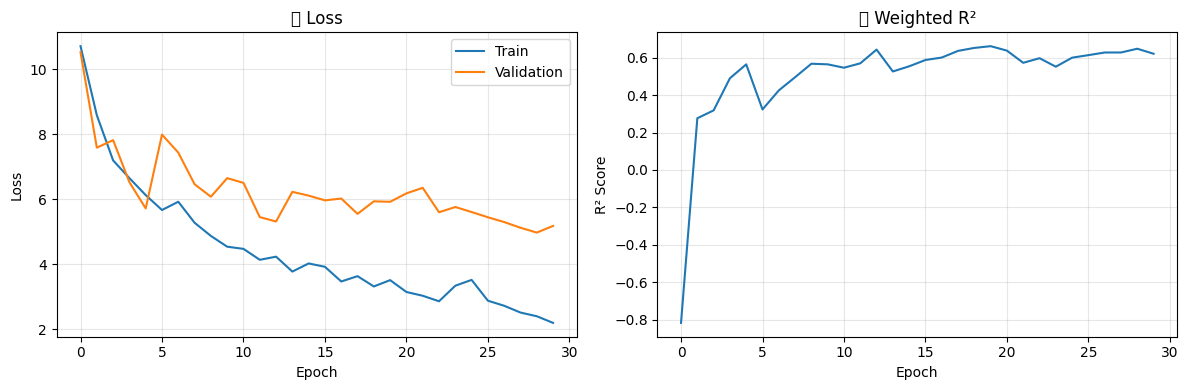


📍 Fold 1 の訓練を開始
💻 使用デバイス: cuda:0

🔄 データローダー作成:
   - 訓練データ (fold != 1):
   📦 データセットサイズ: 285
   - 検証データ (fold == 1):
   📦 データセットサイズ: 72

🎯 訓練開始 (最大 100 エポック)


📊 Fold 1 進捗:   0%|          | 0/100 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 0/100:
      - Train Loss: 11.6515
      - Val Loss: 10.0140
      - Weighted R²: -0.0022
      - Learning Rate: 0.001000
   💾 ベストモデル保存 (R²: -0.0022)


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 10/100:
      - Train Loss: 4.6411
      - Val Loss: 6.0525
      - Weighted R²: 0.4667
      - Learning Rate: 0.001000


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 20/100:
      - Train Loss: 3.2530
      - Val Loss: 5.6532
      - Weighted R²: 0.5353
      - Learning Rate: 0.000500


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   ⏹️  早期停止: 10 エポック改善なし

✅ Fold 1 訓練完了
   🏆 ベストスコア: 0.6198


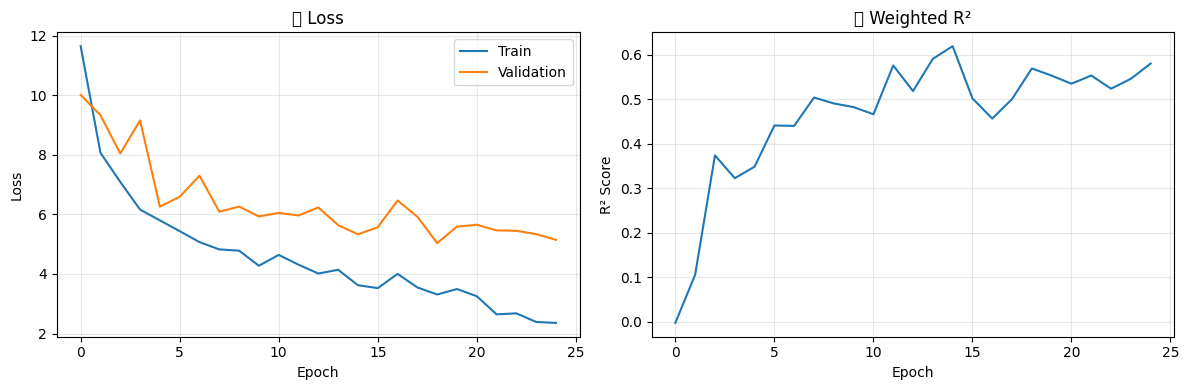


📍 Fold 2 の訓練を開始
💻 使用デバイス: cuda:0

🔄 データローダー作成:
   - 訓練データ (fold != 2):
   📦 データセットサイズ: 286
   - 検証データ (fold == 2):
   📦 データセットサイズ: 71

🎯 訓練開始 (最大 100 エポック)


📊 Fold 2 進捗:   0%|          | 0/100 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 0/100:
      - Train Loss: 10.7748
      - Val Loss: 10.1322
      - Weighted R²: -0.2166
      - Learning Rate: 0.001000
   💾 ベストモデル保存 (R²: -0.2166)


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 10/100:
      - Train Loss: 4.4951
      - Val Loss: 5.7138
      - Weighted R²: 0.6128
      - Learning Rate: 0.001000


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 20/100:
      - Train Loss: 2.9475
      - Val Loss: 5.0306
      - Weighted R²: 0.6371
      - Learning Rate: 0.000500


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   ⏹️  早期停止: 10 エポック改善なし

✅ Fold 2 訓練完了
   🏆 ベストスコア: 0.6898


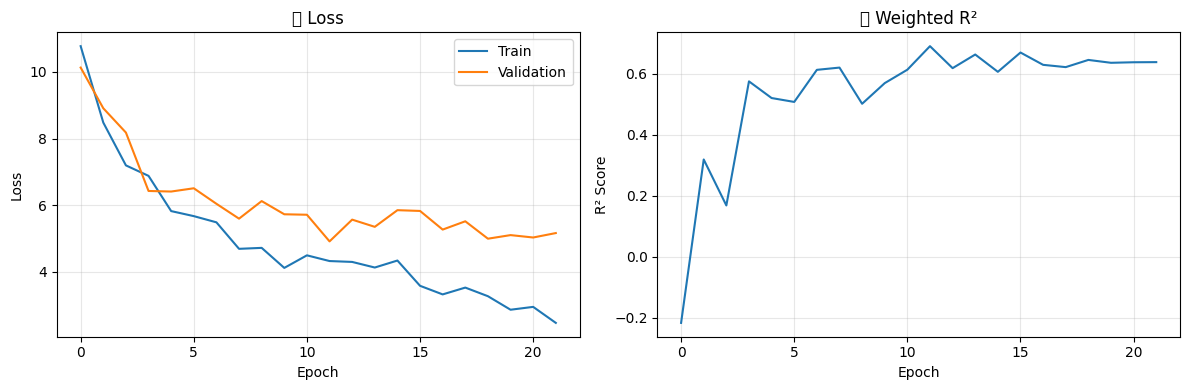


📍 Fold 3 の訓練を開始
💻 使用デバイス: cuda:0

🔄 データローダー作成:
   - 訓練データ (fold != 3):
   📦 データセットサイズ: 286
   - 検証データ (fold == 3):
   📦 データセットサイズ: 71

🎯 訓練開始 (最大 100 エポック)


📊 Fold 3 進捗:   0%|          | 0/100 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 0/100:
      - Train Loss: 10.8939
      - Val Loss: 10.4517
      - Weighted R²: -0.4971
      - Learning Rate: 0.001000
   💾 ベストモデル保存 (R²: -0.4971)


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 10/100:
      - Train Loss: 4.2982
      - Val Loss: 6.5204
      - Weighted R²: 0.5177
      - Learning Rate: 0.001000


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   ⏹️  早期停止: 10 エポック改善なし

✅ Fold 3 訓練完了
   🏆 ベストスコア: 0.6572


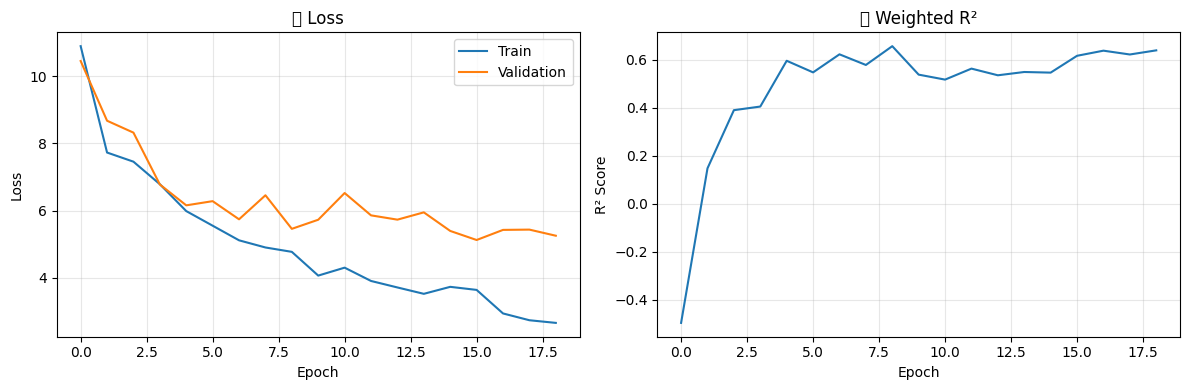


📍 Fold 4 の訓練を開始
💻 使用デバイス: cuda:0

🔄 データローダー作成:
   - 訓練データ (fold != 4):
   📦 データセットサイズ: 286
   - 検証データ (fold == 4):
   📦 データセットサイズ: 71

🎯 訓練開始 (最大 100 エポック)


📊 Fold 4 進捗:   0%|          | 0/100 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 0/100:
      - Train Loss: 11.0588
      - Val Loss: 12.6118
      - Weighted R²: -0.3362
      - Learning Rate: 0.001000
   💾 ベストモデル保存 (R²: -0.3362)


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 10/100:
      - Train Loss: 4.1446
      - Val Loss: 6.2926
      - Weighted R²: 0.4760
      - Learning Rate: 0.001000


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   📈 Epoch 20/100:
      - Train Loss: 2.6601
      - Val Loss: 5.3567
      - Weighted R²: 0.5529
      - Learning Rate: 0.000500


🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]

🏋️  訓練中:   0%|          | 0/9 [00:00<?, ?it/s]

🔍 検証中:   0%|          | 0/3 [00:00<?, ?it/s]


   ⏹️  早期停止: 10 エポック改善なし

✅ Fold 4 訓練完了
   🏆 ベストスコア: 0.5896


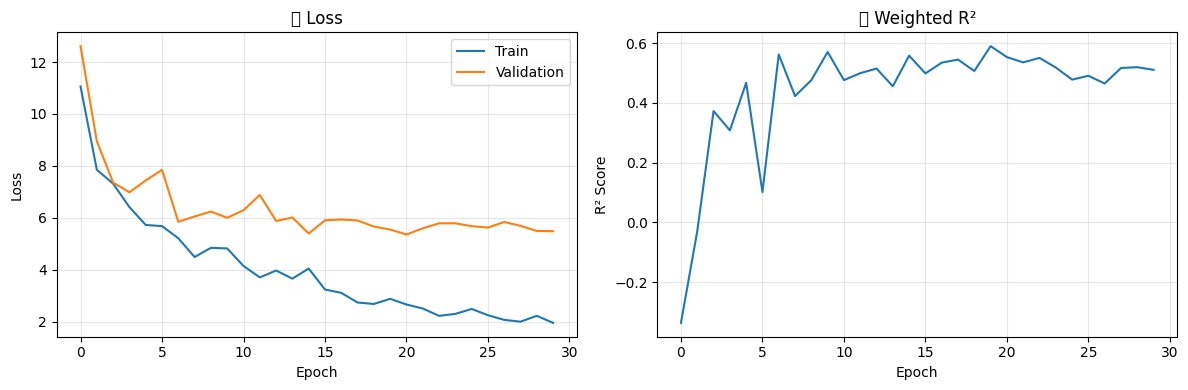


🎉 全Fold訓練完了
📊 各Foldのベストスコア:
   Fold 0: 0.6607
   Fold 1: 0.6198
   Fold 2: 0.6898
   Fold 3: 0.6572
   Fold 4: 0.5896

🏆 平均CV スコア: 0.6434 ± 0.0349


In [9]:
if TRAIN:
    print("\n" + "="*50)
    print("🚀 訓練開始")
    print("="*50)
    
    all_best_scores = []
    
    for fold_idx in range(2 if DEBUG else NFOLD):
        history, best_score = train_fold(train_df, fold=fold_idx)
        all_best_scores.append(best_score)
        
        # 履歴を保存
        history_df = pd.DataFrame(history)
        history_df.to_json(
            f'{OUTPUT_DIR}/history_fold{fold_idx}.jsonl',
            orient='records',
            lines=True,
            force_ascii=False,
        )
        
        # 学習曲線をプロット
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.title('📉 Loss')
        plt.plot(history_df.train_loss, label='Train')
        plt.plot(history_df.val_loss, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.title('📈 Weighted R²')
        plt.plot(history_df.weighted_r2)
        plt.xlabel('Epoch')
        plt.ylabel('R² Score')
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/training_fold{fold_idx}.png', dpi=100)
        plt.show()
    
    # 最終結果
    print("\n" + "="*50)
    print("🎉 全Fold訓練完了")
    print("="*50)
    print(f"📊 各Foldのベストスコア:")
    for i, score in enumerate(all_best_scores):
        print(f"   Fold {i}: {score:.4f}")
    print(f"\n🏆 平均CV スコア: {np.mean(all_best_scores):.4f} ± {np.std(all_best_scores):.4f}")

## 🔮 推論関数

In [10]:
def get_latest_saved_models() -> str:
    """
    保存された最新のモデルディレクトリを取得します。
    
    Returns:
        str: モデルディレクトリのパス
    """
    model_root = '/kaggle/input/csiro-simple-output/pytorch/default/'
    
    latest = 1
    for version in os.listdir(model_root):
        try:
            version = int(version)
        except:
            continue
        if version > latest:
            latest = version
    
    return f'{model_root}/{latest}/trained_models/'


def predict(model: nn.Module, dataloader: DataLoader, device: torch.device) -> np.ndarray:
    """
    モデルで予測を実行します。
    
    Args:
        model (nn.Module): 予測に使用するモデル
        dataloader (DataLoader): 予測データローダー
        device (torch.device): 計算デバイス
    
    Returns:
        np.ndarray: 予測結果
    """
    model.to(device)
    model.eval()
    
    all_outputs = []
    pbar = tqdm(dataloader, desc="🔮 予測中")
    
    with torch.no_grad():
        for images, _ in pbar:
            images = images.to(device)
            outputs = model(images)
            all_outputs.append(outputs.detach().cpu())
    
    outputs = torch.cat(all_outputs).numpy()
    return outputs


def kfold_predict(dataloader: DataLoader, model_dir: str) -> np.ndarray:
    """
    複数のfoldモデルでアンサンブル予測を実行します。
    
    Args:
        dataloader (DataLoader): 予測データローダー
        model_dir (str): モデルが保存されているディレクトリ
    
    Returns:
        np.ndarray: アンサンブル予測結果
    """
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"💻 使用デバイス: {device}")
    
    all_preds = []
    model_files = list(Path(model_dir).glob('*.pth'))
    
    print(f"🔮 {len(model_files)}個のモデルでアンサンブル予測を実行")
    
    for model_file in tqdm(model_files, desc="📦 モデル読み込み中"):
        model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=3)
        model.load_state_dict(torch.load(model_file))
        
        preds = predict(model, dataloader, device)
        all_preds.append(preds)
    
    avg_preds = np.mean(all_preds, axis=0)
    print(f"✅ アンサンブル予測完了")
    
    return avg_preds

## 📝 テストデータ推論 & 提出ファイル作成

In [11]:
print("\n" + "="*50)
print("🔮 テストデータ推論")
print("="*50)

# テストデータ読み込み
test_df = load_and_prepare_data(DATA_ROOT, is_train=False)

# モデルの入力サイズを取得
model_temp = timm.create_model(MODEL_NAME, pretrained=False, num_classes=3)
TARGET_IMAGE_SIZE = model_temp.pretrained_cfg['input_size'][1:]
del model_temp

# DataLoader作成
print("\n📦 テストデータローダー作成:")
test_loader = create_dataloader(
    test_df, 
    TARGET_IMAGE_SIZE, 
    BATCH_SIZE, 
    shuffle=False, 
    aug=False
)

# 推論実行
SAVED_MODELS = OUTPUT_DIR if TRAIN else get_latest_saved_models()
predictions = kfold_predict(test_loader, SAVED_MODELS)

# 予測結果を整形
test_df[['Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g']] = predictions
test_df['GDM_g'] = test_df.Dry_Green_g + test_df.Dry_Clover_g
test_df['Dry_Total_g'] = test_df.GDM_g + test_df.Dry_Dead_g


🔮 テストデータ推論
📂 テストデータ読み込み中...
🖼️  画像読み込み中...


/tmp/ipykernel_20/232827819.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_df = df.groupby(cols).apply(


  0%|          | 0/1 [00:00<?, ?it/s]

✅ データ読み込み完了: 1 サンプル

📦 テストデータローダー作成:
   📦 データセットサイズ: 1
💻 使用デバイス: cuda:0
🔮 5個のモデルでアンサンブル予測を実行


📦 モデル読み込み中:   0%|          | 0/5 [00:00<?, ?it/s]

🔮 予測中:   0%|          | 0/1 [00:00<?, ?it/s]

🔮 予測中:   0%|          | 0/1 [00:00<?, ?it/s]

🔮 予測中:   0%|          | 0/1 [00:00<?, ?it/s]

🔮 予測中:   0%|          | 0/1 [00:00<?, ?it/s]

🔮 予測中:   0%|          | 0/1 [00:00<?, ?it/s]

✅ アンサンブル予測完了


## 💾 提出ファイル作成

In [12]:
print("\n📝 提出ファイル作成中...")
cols = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
sub_df = test_df.set_index('sample_id_prefix')[cols].stack()
sub_df = sub_df.reset_index()
sub_df.columns = ['sample_id_prefix', 'target_name', 'target']
sub_df['sample_id'] = sub_df.sample_id_prefix + '__' + sub_df.target_name

submission_cols = ['sample_id', 'target']
sub_df[submission_cols].to_csv('submission.csv', index=False)

print("✅ submission.csv 作成完了")
print("\n📄 提出ファイルプレビュー:")
print(sub_df[submission_cols].head(10))

print("\n" + "="*50)
print("🎉 全処理完了!")
print("="*50)


📝 提出ファイル作成中...
✅ submission.csv 作成完了

📄 提出ファイルプレビュー:
                    sample_id     target
0  ID1001187975__Dry_Clover_g   1.271315
1    ID1001187975__Dry_Dead_g  25.726288
2   ID1001187975__Dry_Green_g  19.922665
3   ID1001187975__Dry_Total_g  46.920265
4         ID1001187975__GDM_g  21.193979

🎉 全処理完了!
